In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd

In [3]:
def load_data(data_file):
    df = pd.read_csv(data_file)
    texts = df['text'].tolist()
    labels = [1 if sentiment == "positive" else 2 if sentiment == "negative" else 0 for sentiment in df['sentiment'].tolist()]
    return texts, labels

In [4]:
texts, labels = load_data("/content/drive/MyDrive/NLPProject/train.csv")


In [5]:
class TextClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(text, return_tensors='pt', max_length=self.max_length, padding='max_length', truncation=True)
        return {'input_ids': encoding['input_ids'].flatten(), 'attention_mask': encoding['attention_mask'].flatten(), 'label': torch.tensor(label)}


In [6]:
class BERTClassifier(nn.Module):
    def __init__(self, bert_model_name, num_classes):
        super(BERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        x = self.dropout(pooled_output)
        logits = self.fc(x)
        return logits

In [7]:
def train(model, data_loader, optimizer, scheduler, device):
    model.train()
    i=0
    for batch in data_loader:
        i=i+1
        if(i==50):
          break

        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        print("hey",labels)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        print(outputs)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()


In [8]:
def evaluate(model, data_loader, device):
    model.eval()
    predictions = []
    actual_labels = []
    with torch.no_grad():
        i=0
        for batch in data_loader:
            i=i+1
            if(i==50):
              break;
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            predictions.extend(preds.cpu().tolist())
            actual_labels.extend(labels.cpu().tolist())
    return accuracy_score(actual_labels, predictions), classification_report(actual_labels, predictions)

In [9]:
def predict_sentiment(text, model, tokenizer, device, max_length=128):
    model.eval()
    encoding = tokenizer(text, return_tensors='pt', max_length=max_length, padding='max_length', truncation=True)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)
        print(preds)

        return "positive" if preds.item() == 1 else  "negative" if preds.item() == 2 else "neutral"

In [10]:
bert_model_name = 'bert-base-uncased'
num_classes = 3
max_length = 128
batch_size = 30
num_epochs = 30
learning_rate = 2e-5

In [11]:
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)


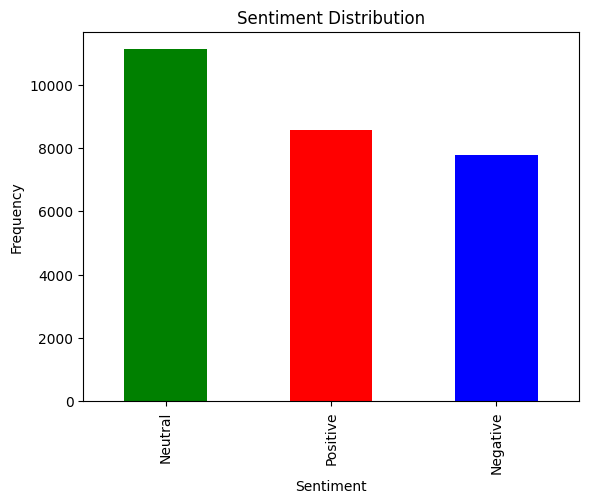

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

label_counts = pd.Series(labels).value_counts()
label_counts.plot(kind='bar', color=['green', 'red', 'blue'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.xticks([1, 2,0], ['Positive', 'Negative', 'Neutral'])
plt.show()


In [13]:
tokenizer = BertTokenizer.from_pretrained(bert_model_name)
train_dataset = TextClassificationDataset(train_texts, train_labels, tokenizer, max_length)
val_dataset = TextClassificationDataset(val_texts, val_labels, tokenizer, max_length)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BERTClassifier(bert_model_name, num_classes).to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [15]:
optimizer = AdamW(model.parameters(), lr=learning_rate)
total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [16]:
print(len(train_dataloader))
for batch in train_dataloader:
    print(len(batch))
    break


733
3


In [17]:
train(model, train_dataloader, optimizer, scheduler, device)

hey tensor([0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 2, 1, 0, 0, 0, 0, 1, 2, 0,
        0, 1, 2, 2, 1, 2])
tensor([[-0.4398, -0.0117,  0.2205],
        [-0.5189, -0.3033, -0.0555],
        [-0.5066, -0.1645,  0.2711],
        [-0.4924, -0.2149,  0.1402],
        [ 0.0487, -0.0479, -0.3125],
        [-0.3436, -0.0805,  0.0401],
        [-0.3536, -0.2765, -0.0051],
        [-0.2837, -0.1297,  0.0779],
        [-0.4235,  0.1262, -0.0521],
        [-0.4560, -0.2079,  0.0831],
        [-0.3571,  0.0688, -0.0083],
        [-0.3474, -0.1708, -0.0320],
        [-0.3974, -0.1627, -0.3865],
        [-0.2219, -0.1395,  0.1358],
        [-0.0600, -0.3749, -0.2129],
        [-0.5576,  0.0194, -0.0622],
        [-0.3459, -0.3222, -0.0722],
        [-0.4296, -0.2192, -0.2555],
        [-0.2343, -0.1939, -0.2315],
        [-0.4059, -0.0904,  0.0282],
        [-0.5904, -0.3752,  0.1373],
        [-0.2479,  0.0555, -0.2729],
        [-0.2853, -0.0750,  0.0665],
        [-0.2404, -0.4570,  0.0509],
 

In [18]:
print(train_dataloader)

In [19]:
accuracy, report = evaluate(model, val_dataloader, device)
print(f"Validation Accuracy: {accuracy:.4f}")
print(report)


Validation Accuracy: 0.5578
              precision    recall  f1-score   support

           0       0.53      0.39      0.45       612
           1       0.52      0.80      0.63       444
           2       0.68      0.54      0.60       414

    accuracy                           0.56      1470
   macro avg       0.58      0.58      0.56      1470
weighted avg       0.57      0.56      0.55      1470



In [22]:
torch.save(model.state_dict(), "bert_classifier.pth")

In [23]:
test_text = ["The movie was excellent and I really enjoyed the performances of the actors.", "product quality was bad","he calls me bella"]

for txt in test_text:
  sentiment = predict_sentiment(txt, model, tokenizer, device)
  print(f"{txt}")
  print(f"Predicted sentiment: {sentiment}")

tensor([1])
The movie was excellent and I really enjoyed the performances of the actors.
Predicted sentiment: positive
tensor([2])
product quality was bad
Predicted sentiment: negative
tensor([0])
he calls me bella
Predicted sentiment: neutral
